# Project Motivation 
Now with 7 million current listings, "accessible in 62 languages across 220+ countries and regions", Airbnb has been gaining popularity since its start in 2008. It is the Uber of the hospitality industry, allowing property owners to list their space and take full control of pricing.
Part of the Inside Airbnb project, Airbnb offers data for cities all over the world. I decided to choose Washington D.C. due to its history, art, culture, and attractions for every type of visitor. Made available to me were review, listing, and host data.
The aim of this post is to delve into the Washington D.C. Airbnb market to find out more about the types of listings, the kind of hosts running businesses, and the reviews Airbnb-ers leave from their experiences. Now, let's see what we find.


# Properties & Pricing:
1. How does pricing vary across neighborhoods? Can I still find a reasonably priced listing in the most expensive neighborhood?
2. How expensive are the top 5% of listings?
3. Does proximity to attractions play a factor in price?
4. Are there common property types, room types, bedroom and bathroom counts?
### Hosts:
5. Do hosts with multiple listings tend to be in certain neighborhoods?
6. Do hosts with multiple listings stick to certain price points?
7. Can we expect better reviews from hosts with businesses?
### Reviews:
8. Does sentiment in reviews tell us which neighborhoods or price ranges are better? 


In [6]:
# imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import json
import ipywidgets as widgets
import plotly
%matplotlib inline

# required chart studio libraries 
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls

# set credentials
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

# my favorite
plt.style.use("fivethirtyeight")

# show full columns
pd.set_option('display.max_columns', None)

# cell width 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [7]:
def w_image(fig, name, width=1500, height=1000):
    
    # write html and png 
    #pio.write_html(fig, file=f"{name}.html", auto_open=True, width=width, height=height)
    py.plot(fig, name, auto_open=False, width=width, height=height)
    fig.write_image(f"{name}.png", width=width, height=height)


## Datasets available to us: listings, reviews, geographical information

In [8]:
# listings data
ls = pd.read_csv("data/listings.csv")
ls_d = pd.read_csv("data/listings 2.csv")

# reviews data
rs = pd.read_csv("data/reviews.csv")
rs_d = pd.read_csv("data/reviews 2.csv")


# geography data
geo = pd.read_csv("data/neighbourhoods.csv")

with open("data/neighbourhoods.geojson") as jsonfile:
    geojson = json.load(jsonfile)

/Users/ldugom/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.



## Preliminary: Where are the neighbourhoods in DC?

In [ ]:
import plotly.express as px

# set token
px.set_mapbox_access_token("pk.eyJ1IjoibGF3cmVuY2VkIiwiYSI6ImNrODFzZnFnNzA0YmczZW9nNWN4aTFvdngifQ.VlB5-L7owXKEXo8JEePk7w")
fig = px.choropleth_mapbox(ls, geojson=geojson, title="Washington D.C. Neighbourhood Map",
                           locations="neighbourhood", featureidkey="properties.neighbourhood",opacity=0.5,
                           mapbox_style="light", zoom=11)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()



## Explore numerical attributes

In [10]:
# melt listings data for graphing purposes 
melted_ls = pd.melt(ls,id_vars=['id', 'name', 'host_id', 'host_name', 'neighbourhood_group','neighbourhood', 'latitude', 'longitude'], value_vars=ls.select_dtypes(include=np.number).iloc[:, 5:].columns.tolist())


In [ ]:
# create dropdown for attributes in melted dataframe
dropdown_attribute = widgets.Dropdown(options = sorted(melted_ls.variable.unique()))

# output
output = widgets.Output()


def view_attribute(attribute):
    
    # clear output for new attribute to be plotted 
    output.clear_output()
    
    # filter df to selected attribute
    filtered = melted_ls[melted_ls['variable'] == attribute].copy()
    
    # filter out outliers 
    filtered = filtered[filtered.value.between(filtered.value.quantile(.10), filtered.value.quantile(.80))]
 
    with output:
        # set token
        px.set_mapbox_access_token("pk.eyJ1IjoibGF3cmVuY2VkIiwiYSI6ImNrODFzZnFnNzA0YmczZW9nNWN4aTFvdngifQ.VlB5-L7owXKEXo8JEePk7w")
        fig = px.scatter_mapbox(filtered.rename({'value':'Listing Price'}, axis=1), lat="latitude", lon="longitude", color="Listing Price", template="gridon", 
                                color_continuous_scale=plotly.colors.diverging.RdYlGn,
                                   opacity=0.4, center={"lat": 38.9072, "lon": -77.0369},
                                   mapbox_style="light", zoom=11)

        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.show()

# change attribute
def dropdown_attribute_handler(change):
    view_attribute(change.new)
    
dropdown_attribute.observe(dropdown_attribute_handler, names="value")
display(dropdown_attribute)
display(output)

#  How does pricing look across neighborhoods? Can I still find a relatively cheaper priced listing in one of the more expensive neighborhoods?


For the bottom 95% of listings, we see neighborhood averages range from $83 to $186. Among the 39 neighborhoods in the listings data, Georgetown, Southwest/Waterfront, and Spring Valley are the most expensive.
While remaining within the top 10 most expensive neighborhoods, you can still save an upwards of $50–100/night by choosing a less expensive offering in a local neighborhood. When comparing the 10 most expensive neighborhoods to the 10 most affordable neighborhoods, you can potentially save double by choosing an average-priced Airbnb out of the lower-priced tier of neighborhoods.
The table reveals that 9 of the 10 most expensive neighborhoods also have the biggest interquartile ranges, which means you can still find a reasonably priced listing in an expensive area. With higher-priced neighborhoods having wider price ranges, the potential exists for an affordable Airbnb in an upscale neighborhood.

In [73]:
# calculate outliers within neighbourhoods 
stdev = 3.0

zscores = ls[['neighbourhood', 'price']].groupby('neighbourhood').transform(
    lambda group: (group - group.mean()).div(group.std())).abs()

outliers = zscores > stdev

# take out outliers 
ls_nonoutliers = ls[~outliers.any(axis=1)].copy()


# agg all the observations by nieghbourhood to get median and mean 
summary = ls.groupby("neighbourhood").agg({'price':['mean', 'median', 'count']}).reset_index()
summary.columns = ['Neighbourhood', 'Mean Price', 'Median Price', '# of listings']

# strip outliers and redo agg
summary_nonoutliers = ls_nonoutliers.groupby("neighbourhood").agg({'price':['mean', 'count']}).reset_index()
summary_nonoutliers.columns = ['Neighbourhood', 'Mean Price', '# of listings']

# merge 
summary_final = pd.merge(summary, summary_nonoutliers, on='Neighbourhood', suffixes=[" with outliers", " without outliers"])
summary_final["# of outliers"] = summary_final["# of listings with outliers"] - summary_final["# of listings without outliers"] 
summary_final.drop(['# of listings without outliers'], axis=1, inplace=True)

# mean price by nieghborhood 
(
    summary_final
    .sort_values(["Mean Price without outliers"], ascending=False)[['Neighbourhood', 'Mean Price with outliers', 'Mean Price without outliers', 'Median Price', '# of outliers']]
    .style.background_gradient(cmap='RdYlGn', subset=['Mean Price with outliers', 'Median Price', 'Mean Price without outliers']) 
    
          
)

,Neighbourhood,Mean Price with outliers,Mean Price without outliers,Median Price,# of outliers
36,"West End, Foggy Bottom, GWU",304.280822,298.625430,150.000000,1
11,"Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street",274.610526,247.212766,173.000000,4
17,"Georgetown, Burleith/Hillandale",296.938224,235.964844,162.000000,3
31,"Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point",270.191489,220.862637,189.500000,6
29,"Shaw, Logan Circle",290.917910,210.158850,144.500000,9
32,"Spring Valley, Palisades, Wesley Heights, Foxhall Crescent, Foxhall Village, Georgetown Reservoir",288.104651,209.250000,122.500000,2
2,"Capitol Hill, Lincoln Park",260.604317,207.454545,135.000000,9
20,"Howard University, Le Droit Park, Cardozo/Shaw",333.938719,201.375000,130.000000,7
12,"Dupont Circle, Connecticut Avenue/K Street",250.692416,195.617232,142.500000,4
5,"Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace",199.610619,179.964286,115.000000,1


## Which neighborhoods have the widest variety of price ranges?  

In [ ]:
# Looking at the averages across neighborhoods, it does look like one can find a relatively cheaper listing in a more expensive neighborhood. 
# In fact, nine of the top ten most expensive neighborhoods also have the biggest IQRs across all niehgborhoods, meaning that we can still find aparmtents less than
# half of their averages in their neighborhoods (largest range of values)

In [75]:
# filter out top 5% to be fair
ls_price_summary = ls.query("price <= price.quantile(.95)")

ls_price_summary = ls_price_summary.groupby("neighbourhood")['price'].describe().reset_index()
ls_price_summary['IQR'] = ls_price_summary['75%']  - ls_price_summary['25%']

(
ls_price_summary
[["neighbourhood", 'mean', 'std', '25%', '50%', '75%', 'IQR']].round(1)
.sort_values(["IQR","mean"], ascending=False).style.background_gradient(cmap="RdYlGn")
    .format(lambda x: "${:.0f}".format(x) if type(x) != str else x)

)

,neighbourhood,mean,std,25%,50%,75%,IQR
17,"Georgetown, Burleith/Hillandale",$186,$120,$99,$150,$238,$139
31,"Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point",$193,$115,$105,$179,$241,$136
32,"Spring Valley, Palisades, Wesley Heights, Foxhall Crescent, Foxhall Village, Georgetown Reservoir",$153,$103,$87,$100,$222,$135
15,"Fairfax Village, Naylor Gardens, Hillcrest, Summit Park",$129,$88,$65,$99,$195,$130
11,"Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street",$198,$120,$115,$160,$233,$118
20,"Howard University, Le Droit Park, Cardozo/Shaw",$161,$106,$92,$125,$199,$108
29,"Shaw, Logan Circle",$176,$121,$99,$138,$206,$106
2,"Capitol Hill, Lincoln Park",$157,$108,$90,$126,$186,$96
12,"Dupont Circle, Connecticut Avenue/K Street",$162,$97,$99,$136,$192,$94
36,"West End, Foggy Bottom, GWU",$169,$114,$100,$135,$192,$92


In [76]:
# top and bottom twelve nieghborhoods
most_expensive_neighbourhoods = summary_final.sort_values(["Mean Price without outliers"], ascending=False)[:10].Neighbourhood.values.tolist()
cheapest_neighbourhoods= summary_final.sort_values(["Mean Price without outliers"])[:10].Neighbourhood.values.tolist()

top = ls[ls.neighbourhood.isin(most_expensive_neighbourhoods + cheapest_neighbourhoods)]
top['category'] = top['neighbourhood'].apply(lambda x: 'Top 10 Cheapest' if x in cheapest_neighbourhoods else 'Top 10 Most Expensive')


# you son average almost 3x your money by choosing a nieghbourhood from the 10 cheapest rather than the 1- most expsensive 
top.groupby("category").mean()['price'].reset_index().rename({'price':'Average price in Category'}, axis=1) 

/Users/ldugom/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,category,Average price in Category
0,Top 10 Cheapest,111.670829
1,Top 10 Most Expensive,277.131775


## Looking at the 10 most expensive and 10 most inexpensive neighbourhoods visually (39 total)

In [19]:
px.set_mapbox_access_token("pk.eyJ1IjoibGF3cmVuY2VkIiwiYSI6ImNrODFzZnFnNzA0YmczZW9nNWN4aTFvdngifQ.VlB5-L7owXKEXo8JEePk7w")
fig = px.scatter_mapbox(top, lat="latitude", lon="longitude", color="category", template="simple_white",center={"lat": 38.895, "lon": -77.024},
                           mapbox_style="basic", zoom=10)

fig.show()

In [17]:
# average IQR
ls_price_summary.IQR.mean()

# median IQR
ls_price_summary.IQR.median()

70.0

## How expensive is the top 25%? 
### Answer: We can see that top listings start at  ~ \\$200, with a few going all the way to $10,000 ! Georgetown, Capitol, Hill and Downtown/Chinatown seem to pop out the most.

In [20]:
# clean price 
ls_d["price"] = ls_d["price"].str[1:].str.replace(",","").astype(float)

# detect outliers (169 total)
outliers_df = ls_d[ls.price.between(ls_d.price.quantile(.75), ls_d.price.quantile(1))].copy().dropna(subset=["beds"])

sns.set_style("dark") 
sns.set_palette("Set3")

fig = px.scatter(outliers_df, y="neighbourhood_cleansed", x="price", size="beds", title="Top 25% of listings<br>sized by bedroom count",
                 color="beds", template="plotly_dark", color_continuous_scale="sunset", width=1500, height=1000)

fig.show()

In [ ]:
# write out figure 
py.plot(fig, "top25%", auto_open=False, width=1700, height=1250)


## From a glance, it looks like the more expensive listings tend to be closer to downtown. Can wee assume the farther you move away from the center of DC, the more likely you are to find a cheaper listing?

In [80]:
# bottom 95%
ls_95 = ls.query("price <= price.quantile(.95)").copy()
lsd_95 = ls_d.query("price <= price.quantile(.95)").copy()

#create bins to eliminate outliers from dominating continuous scale
ls_95['Price Decile'] = pd.qcut(ls_95['price'], 10)
lsd_95['Price Decile'] = pd.qcut(lsd_95['price'], 10)
ls['Price Decile'] = pd.qcut(ls['price'], 10)



# set token
px.set_mapbox_access_token("pk.eyJ1IjoibGF3cmVuY2VkIiwiYSI6ImNrODFzZnFnNzA0YmczZW9nNWN4aTFvdngifQ.VlB5-L7owXKEXo8JEePk7w")
fig = px.scatter_mapbox(ls_95.sample(frac=.60), lat="latitude", lon="longitude", color="Price Decile", template="simple_white", opacity=0.5, 
                         color_discrete_sequence=px.colors.diverging.RdYlGn, category_orders={"Price Decile":sorted(ls_95['Price Decile'].unique().tolist())}, hover_data=["neighbourhood", "price"],
          
                 center={"lat": 38.895, "lon": -77.024},
                           mapbox_style="basic", zoom=10.5)


fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#py.plot(fig, "price deciles", auto_open=False, width=1500, height=1200)


In [ ]:
fig.write_image("binned_prices.png", height=850, width=1200)

## To test our idea about distance to downtown/attractions and being in more of an expensive price range, we'll calculate the distance to Capital One Arena in Downtown DC as well as the Washington Monument, which is at thecenter of a lot of the DC attractions

In [25]:
monument = {'lat':38.8872036, 'lon':-77.045968}
arena = {'lat':38.8980942,'lon':-77.0208438}
center = {'lat':38.9072,'lon':-77.0369}
wh = {'lat': 38.8977, 'lon':-77.0365}
from math import radians, cos, sin, asin, sqrt


def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 
    return c * r

## calculate each properties distance to washington monument and capital one arena

In [77]:
ls_d["distance_to_monument"] = ls_d[['latitude', 'longitude']] \
    .apply(lambda row: haversine(row['latitude'], row['longitude'], monument.get("lat"), monument.get("lon")), axis=1)


ls_d["distance_to_arena"] = ls_d[['latitude', 'longitude']] \
    .apply(lambda row: haversine(row['latitude'], row['longitude'], arena.get("lat"), arena.get("lon")), axis=1)


ls_d["distance_to_center"] = ls_d[['latitude', 'longitude']] \
    .apply(lambda row: haversine(row['latitude'], row['longitude'], center.get("lat"), center.get("lon")), axis=1)


ls_d["distance_to_whitehouse"] = ls_d[['latitude', 'longitude']] \
    .apply(lambda row: haversine(row['latitude'], row['longitude'], wh.get("lat"), wh.get("lon")), axis=1)


In [81]:
# concatenate correlations and price deciles
distance_corrs = pd.concat([ls_d.select_dtypes(include=np.number), pd.get_dummies(ls['Price Decile'])], axis=1).corr()[["distance_to_monument", "distance_to_arena", "distance_to_center", "distance_to_whitehouse"]].reset_index().dropna()

In [82]:
# look at correlations overall 
distance_corrs.round(3).sort_values("distance_to_monument").style.background_gradient(low=0.0, high=.90)


,index,distance_to_monument,distance_to_arena,distance_to_center,distance_to_whitehouse
9,latitude,-0.375000,-0.158000,-0.373000,-0.354000
37,review_scores_location,-0.280000,-0.137000,-0.256000,-0.255000
40,calculated_host_listings_count_entire_homes,-0.163000,-0.088000,-0.150000,-0.153000
6,host_listings_count,-0.159000,-0.074000,-0.139000,-0.143000
7,host_total_listings_count,-0.159000,-0.074000,-0.139000,-0.143000
39,calculated_host_listings_count,-0.156000,-0.087000,-0.144000,-0.147000
15,square_feet,-0.133000,-0.103000,-0.139000,-0.141000
24,minimum_nights_avg_ntm,-0.115000,-0.041000,-0.096000,-0.098000
21,maximum_minimum_nights,-0.115000,-0.042000,-0.096000,-0.098000
54,"(135.0, 165.0]",-0.074000,-0.057000,-0.073000,-0.074000


## Answer: slightly negative associaton for wh/monument distances, location review scores, host listing count. Weak postive correlation betweeen bedrooms, availability and lowest-priced decile of listings.

## Spatial Correlation 

In [83]:
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lps
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
#from pysal.contrib.viz import mapping as maps

In [ ]:
ls_d = gpd.sjoin(gdf, bl_gdf, how='inner', op='intersects', lsuffix='left', rsuffix='right')
median_price_gb = sj_gdf['price'].groupby([sj_gdf['neighbourhood_group']]).mean()
median_price_gb

In [62]:
from shapely.geometry import shape
gdf = gpd.read_file("data/neighbourhoods.geojson")

In [113]:
# groupby median/mean
grouped_med = ls.groupby('neighbourhood')['price'].median()
grouped_mean = ls.groupby('neighbourhood')['price'].mean()

In [271]:
# merge 
gdf_mean = gdf.join(grouped_mean, on='neighbourhood')
gdf_med = gdf.join(grouped_med, on='neighbourhood')

No handles with labels found to put in legend.


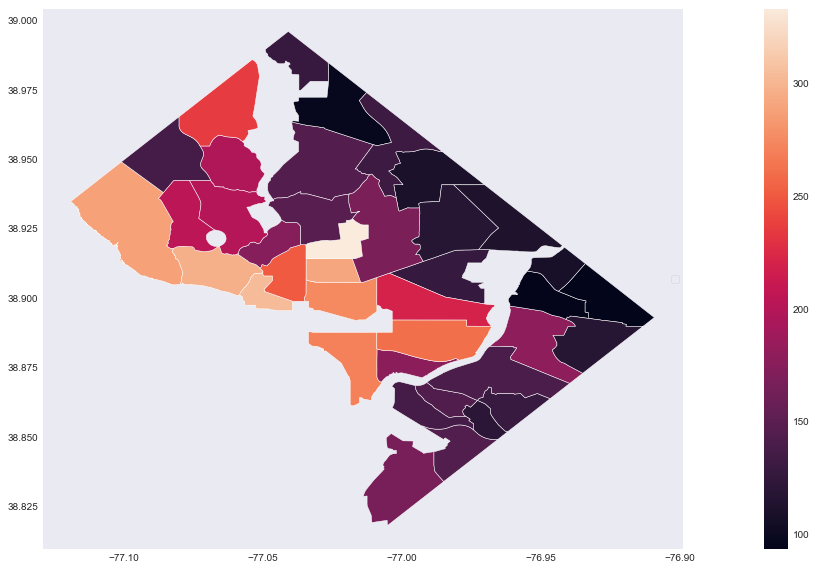

In [272]:
gdf_mean.plot(column='price', figsize=(25,10), legend=True)
plt.legend(loc='right')

### 3 bins

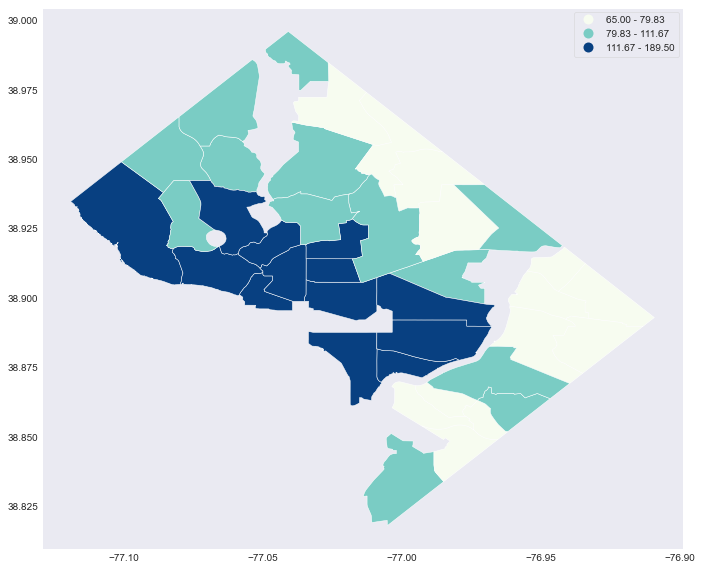

In [315]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
gdf_med.plot(column='price', scheme='Quantiles', k=3, cmap='GnBu', legend=True, ax=ax)

## Spatial Similarity using Queen, Rook, KNN distance types


In [359]:
from libpysal.weights import Queen, Rook, KNN


### The first set of spatial weights we illustrate use notions of contiguity to define neighboring observations. R


##Rook neighbors are those states that share an edge on their respective borders:
w_rook = Rook.from_dataframe(gdf_med)

w_rook.n


w_rook.pct_nonzero


/Users/ldugom/anaconda3/envs/ds/lib/python3.6/site-packages/libpysal/weights/weights.py:167: UserWarning:

The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 30.



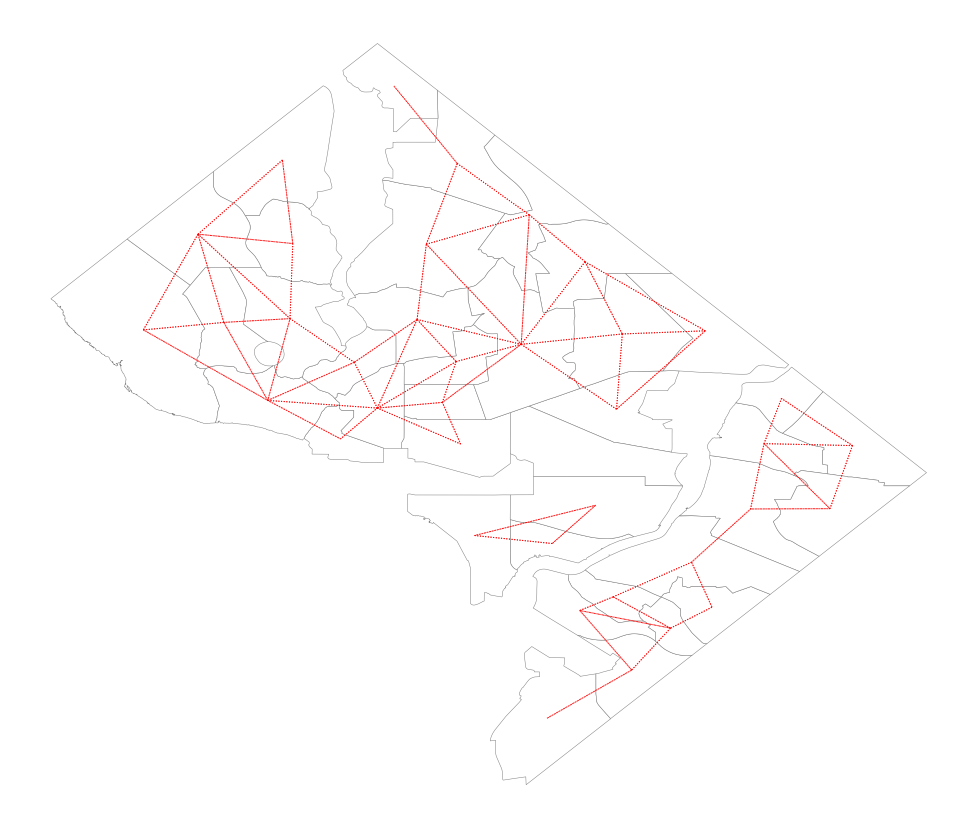

In [383]:
ax = gdf_med.plot(edgecolor='grey', facecolor='w', figsize=(20,15))
f,ax = w_rook.plot(gdf_med, ax=ax,
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()


In [384]:
w_rook.neighbors[1] # the first location has two neighbors at locations 1 and 22



[0, 2, 28]

In [375]:
gdf_med.neighbourhood[w_rook.neighbors[6] ]

14               Georgetown, Burleith/Hillandale
15    Dupont Circle, Connecticut Avenue/K Street
Name: neighbourhood, dtype: object

In [389]:
## Queen neighbors are based on a more inclusive condition that requires only a shared vertex between two states:

w_queen = Queen.from_dataframe(gdf_med)

w_queen.n == w_rook.n


/Users/ldugom/anaconda3/envs/ds/lib/python3.6/site-packages/libpysal/weights/weights.py:167: UserWarning:

The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 30.



True

In [390]:
(w_queen.pct_nonzero > w_rook.pct_nonzero) == (w_queen.n == w_rook.n)


True

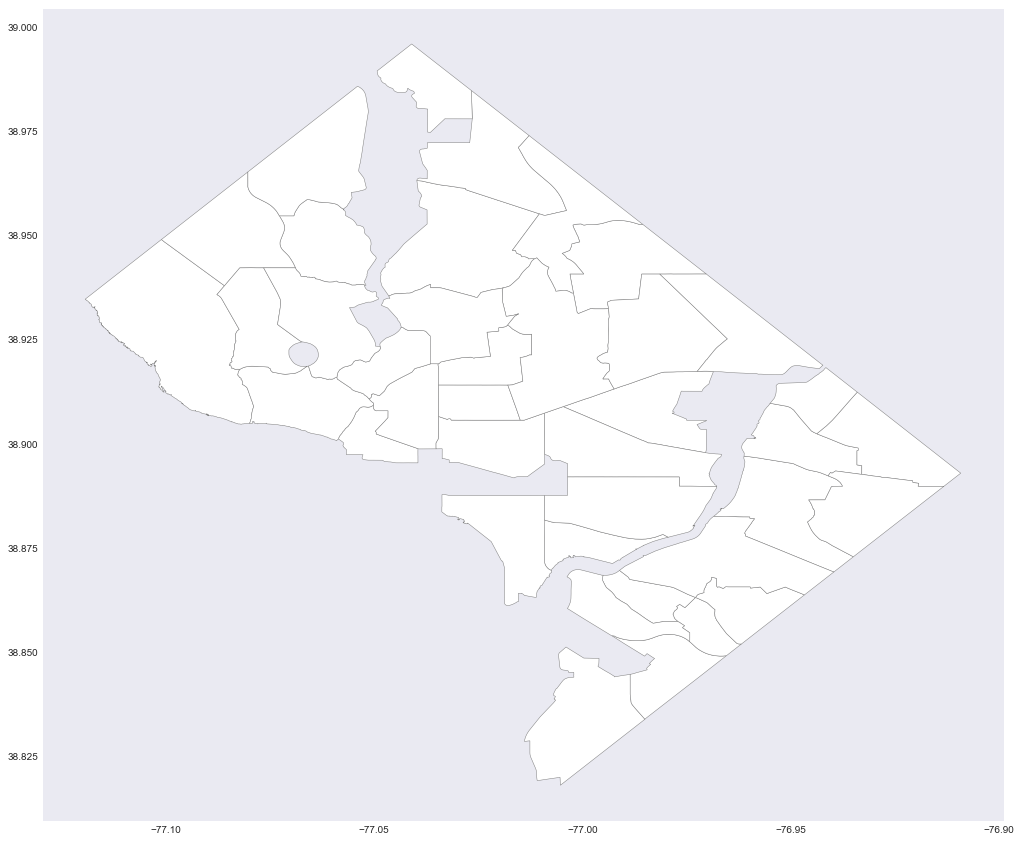

In [394]:
x = gdf.plot(edgecolor='grey', facecolor='w', figsize=(20,15))
f,ax = w_queen.plot(gdf_med, ax=ax,
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

In [395]:
w_queen.histogram


[(0, 1),
 (1, 2),
 (2, 6),
 (3, 12),
 (4, 11),
 (5, 4),
 (6, 1),
 (7, 1),
 (8, 0),
 (9, 1)]

In [396]:
w_rook.histogram


[(0, 1), (1, 2), (2, 8), (3, 12), (4, 10), (5, 3), (6, 1), (7, 1), (8, 1)]

In [397]:
c9 = [idx for idx,c in w_queen.cardinalities.items() if c==9]


In [403]:
w_knn = KNN.from_dataframe(gdf, k=4)


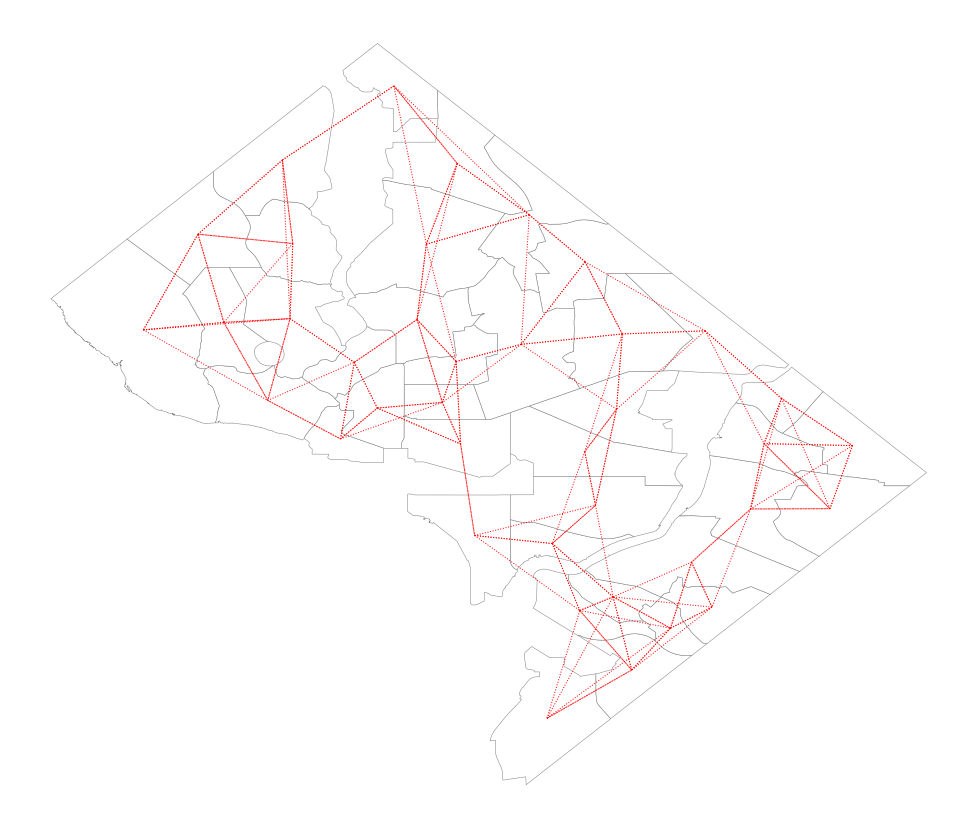

In [405]:
ax = gdf.plot(edgecolor='grey', facecolor='w', figsize=(20,15))
f,ax = w_knn.plot(gdf, ax=ax,
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

In [317]:
wq =  lps.weights.KNN.from_dataframe(gdf_med, k=3)
wq.transform = 'r'

"%.3f"%wq.pct_nonzero

'7.692'

## Attribute Similarity 


In [318]:
y = gdf_med.price.copy()
ylag = lps.weights.lag_spatial(wq, y)


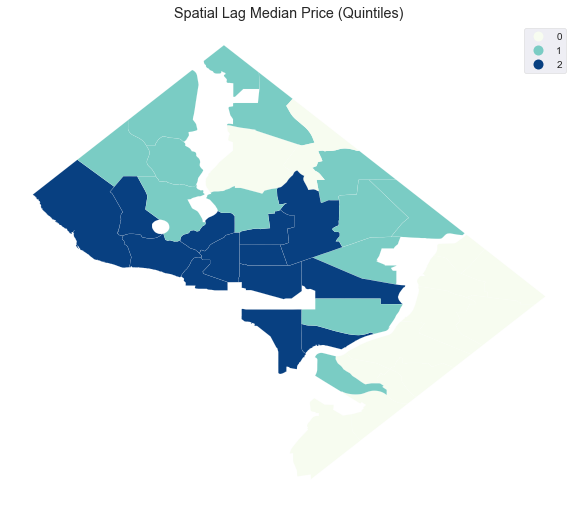

In [320]:
import mapclassify as mc
ylagq3 = mc.Quantiles(ylag, k=3)

f, ax = plt.subplots(1, figsize=(9, 9))
gdf_med.assign(cl=ylagq3.yb).plot(column='cl', categorical=True, \
        k=3, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Median Price (Quintiles)")

plt.show()

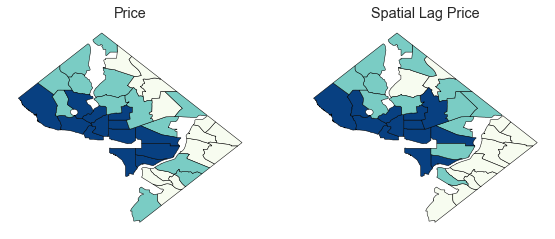

In [344]:
### price vs spatially lagged price
gdf_med['lag_median_pri'] = ylag
f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
gdf_med.plot(column='price', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=3, cmap='GnBu')
ax[0].set_title("Price")
gdf_med.plot(column='lag_median_pri', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=3)
ax[1].set_title("Spatial Lag Price")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [345]:
# make below or above column for the median
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb] 
gdf_med['yb'] = yb

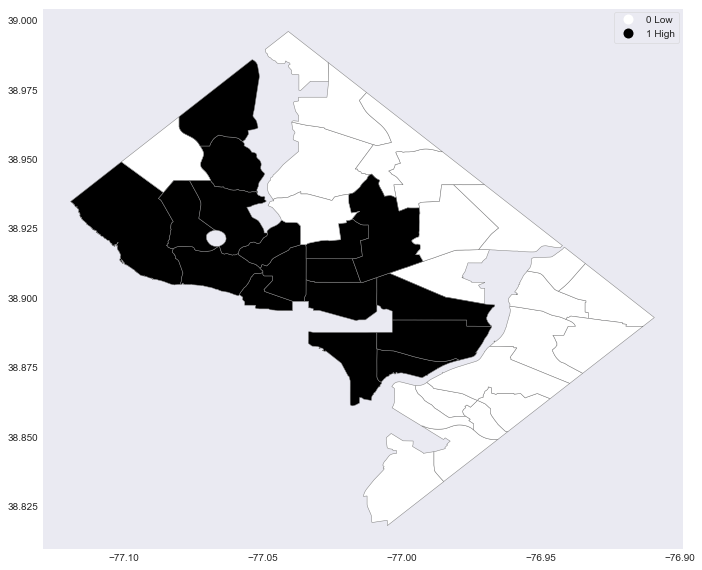

In [346]:
### plt the neighborhoods above the median 
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
gdf_med.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

In [336]:
wq.transform = 'r'
y = gdf_med['price']
mi = esda.moran.Moran(y, wq)


In [337]:
mi.I


0.6870103209791685

Text(0.5, 0, "Moran's I")

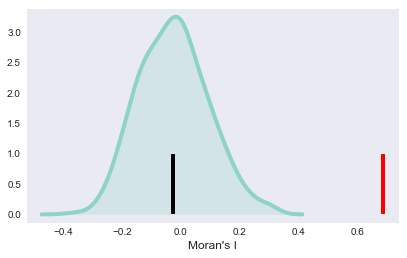

In [338]:
import seaborn as sbn
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

In [339]:
mi.p_sim


0.001

### Local Autocorrelation: Hot Spots, Cold Spots, and Spatial Outliers¶


In [340]:
np.random.seed(12345)
import esda

wq.transform = 'r'
lag_price = lps.weights.lag_spatial(wq, gdf_med['price'])


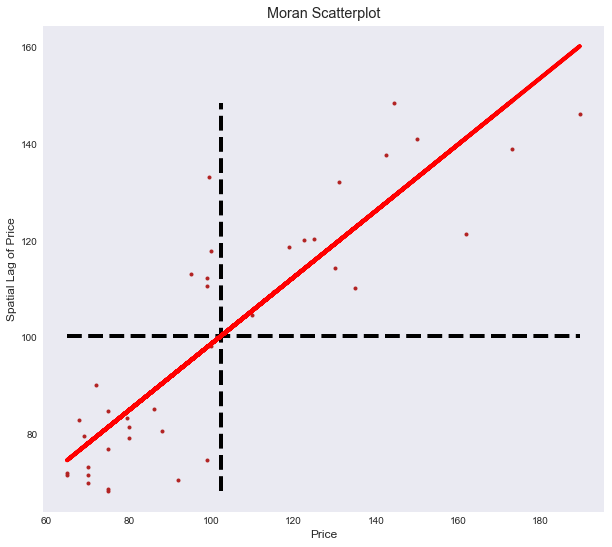

In [341]:
price = gdf_med['price']
b, a = np.polyfit(price, lag_price, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(price, lag_price, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(price.mean(), lag_price.min(), lag_price.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(lag_price.mean(), price.min(), price.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(price, a + b*price, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Price')
plt.xlabel('Price')
plt.show()

In [297]:
### p-values

li = esda.moran.Moran_Local(y, wq)


In [298]:
li.q


array([3, 3, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 2, 1, 1, 1, 1, 3, 3, 1, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 2, 2, 3, 3, 2, 1, 1])

In [299]:
(li.p_sim < 0.05).sum()


14

In [301]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4


In [302]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

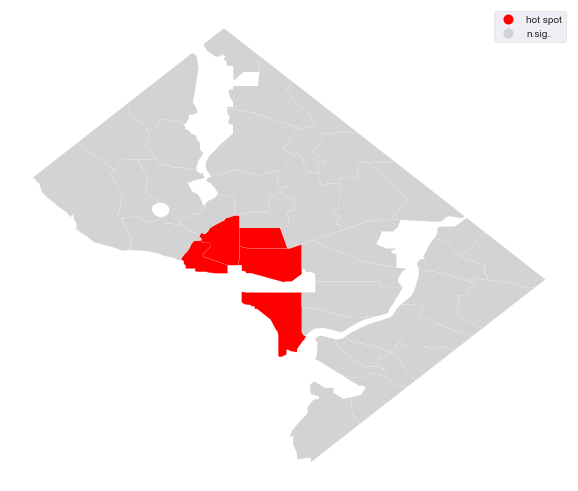

In [303]:
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_med.assign(cl=labels).plot(column='cl', categorical=True, \
        k=3, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

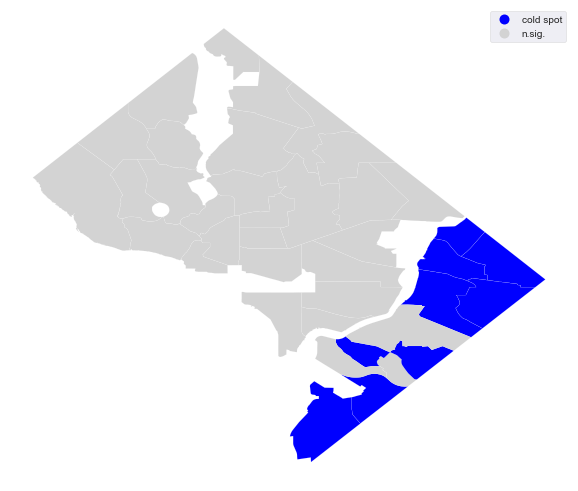

In [304]:
### cold spots
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]


from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_med.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

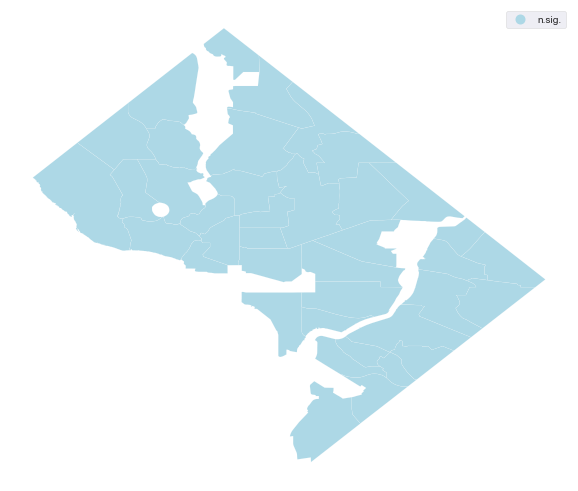

In [305]:
spots = ['n.sig.', 'doughnut']
labels = [spots[i] for i in doughnut*1]

 
from matplotlib import colors
hmap = colors.ListedColormap(['lightblue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_med.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()


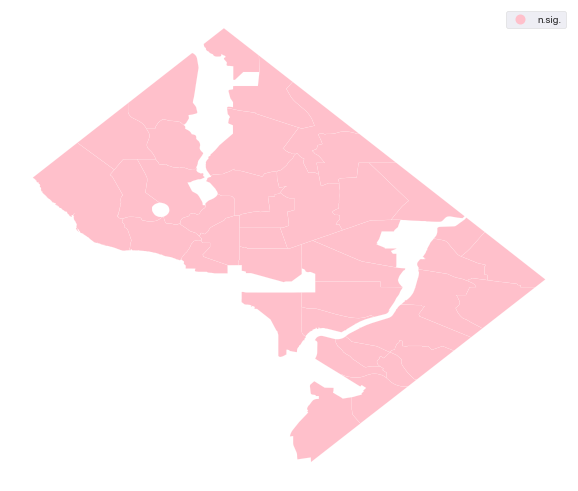

In [306]:

spots = ['n.sig.', 'diamond']
labels = [spots[i] for i in diamond*1]


from matplotlib import colors
hmap = colors.ListedColormap(['pink', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_med.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [307]:

sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

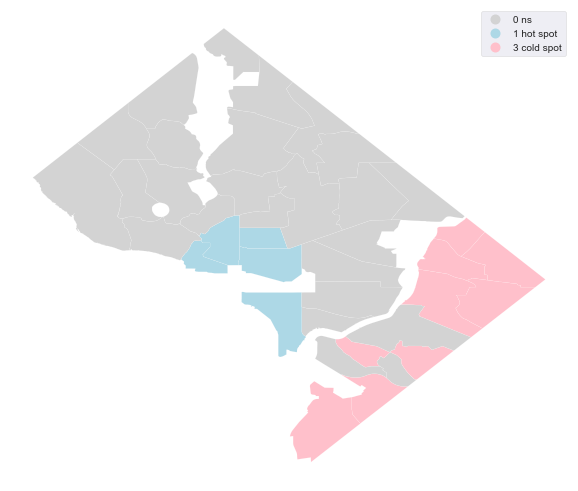

In [309]:
from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_med.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()


# Question 2: What kind of properties are these listings (property type, room type, bedroom count, bathroom count, etc.)

### Property Types: 44% Apartments, 20% Houses, 15% Townhouses (3 form biggest share)

In [ ]:
# groupby prop type and then figure their share overall
proptypes = (
                ls_d.
                    groupby("property_type").count()["price"]
                    .reset_index().rename({'price':'# of listings'}, axis=1)
)


(
    proptypes
        .sort_values("# of listings", ascending=False)
        .assign(share=proptypes["# of listings"]/ls_d.shape[0])
        .style.background_gradient(cmap='Purples', subset=['share'])
    

)

In [ ]:
prop_summary = ls_d.groupby(["neighbourhood_cleansed", "property_type"])['id'].count().reset_index().rename({"id":"listing count"},axis=1).sort_values("listing count",ascending=False)
prop_fig = px.bar(prop_summary.sort_values("listing count",ascending=False),
       title="Property Type by Neighborhood",x='neighbourhood_cleansed', y="listing count", color="property_type", 
                  template="plotly_dark", height=900, color_discrete_sequence=plotly.colors.qualitative.Light24)


In [ ]:
prop_fig.update_xaxes(title='Neighborhood')

In [ ]:
# save
py.plot(prop_fig, "property_types", auto_open=False, width=1700, height=1250)


### Room Types: We can see that the overwhelming majority of listings are entire homes/apartments ( 71%) , followed by private rooms (~25%).

In [ ]:
roomtypes = (
                ls_d.
                    groupby("room_type").count()["price"]
                    .reset_index().rename({'price':'# of listings'}, axis=1)
)


(
    roomtypes
        .sort_values("# of listings", ascending=False)
        .assign(share=roomtypes["# of listings"]/ls_d.shape[0])
        .style.background_gradient(cmap='Blues', subset=['share'])
    

)

In [ ]:
# set token
px.set_mapbox_access_token("pk.eyJ1IjoibGF3cmVuY2VkIiwiYSI6ImNrODFzZnFnNzA0YmczZW9nNWN4aTFvdngifQ.VlB5-L7owXKEXo8JEePk7w")
fig = px.scatter_mapbox(ls_d.dropna(subset=['beds']), lat="latitude", lon="longitude", color="room_type", template="simple_white", size="beds",
                          hover_data=["neighbourhood", "price"],
                           center={"lat": 38.895, "lon": -77.024},
                           mapbox_style="basic", zoom=11.5)

fig.update_layout(margin={"r":5,"t":0,"l":0,"b":0})
py.plot(fig, "room_types", auto_open=False, width=1500, height=100)


### Summary statistics for type of property types: mode of price, bathrooms, bedrooms and beds

In [ ]:
prop_df = ls_d[['price', 'bathrooms','bedrooms','beds', 'property_type']].copy()
prop_df = prop_df.groupby("property_type").agg([('mode', lambda x: x.value_counts().index[0]),'count', 'mean']).reset_index()
prop_df.columns = ['_'.join(col).strip() for col in prop_df.columns.values]
prop_df.rename({'beds_count':'number_of_listings'}, axis=1, inplace=True)
prop_df.drop([col for col in prop_df.columns if "count" in col], axis=1, inplace=True)
prop_df.sort_values("number_of_listings", ascending=False)

# Question 3 (Host Analysis):  Are there hosts that have multiple listings/have businesses using Aribnb? Do they individually tend to be in certain neighborhoods? Do they stick certain price points? Are their reviews impeccable due to their experience?

## Are there hosts that have multiple listings/have businesses using Aribnb?

In [ ]:
ls_subset = ls_d[['id', 'host_id','host_name', 'host_about', 'host_response_time','host_since', 
      'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'neighbourhood',
      'latitude', 'longitude', 'room_type', 'property_type', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
      'availability_30', 'availability_60', 'availability_90','availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 
      'review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value',
      'reviews_per_month']].copy()


In [ ]:
# hosts that have more than one listing 
host_summary = (
    ls_subset
        .groupby(["host_id", "host_name"])
        .count().reset_index()
        .sort_values("id", ascending=False)
        .iloc[:,:3]
        .rename({"id":"# of listings"}, axis=1)
    )

host_summary_multiple = host_summary[host_summary["# of listings"] > 1]



## Answer 1: 46% of the listings are owned by hosts with multiple listings. Thes guys are probably running businesses 

In [ ]:
np.sum(host_summary_multiple["# of listings"]) / np.sum(host_summary["# of listings"]) 

## Do these hosts have good scores and reviews? 


In [ ]:
host_reviews = host_summary_multiple.merge(ls_subset, on = ['host_id', 'host_name'])

In [ ]:
# weight the scores of the hosts that have more than one listing by "reviews per month"
host_grouped = (
                host_reviews
                    .dropna()
                    .groupby(['host_id', 'host_name'])
                    [['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value',
                          'reviews_per_month']]
)

(
    # collect weighted averages 
    host_grouped
        .apply(lambda x: pd.Series(np.average(x[['review_scores_rating','review_scores_accuracy',
                                                 'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                                                 'review_scores_location','review_scores_value']], weights=x["reviews_per_month"], axis=0),
                                   ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
                                    'review_scores_communication','review_scores_location','review_scores_value']))
    
    # merge in helpful information 
    .merge(host_summary_multiple, on=['host_id', 'host_name'])
    .sort_values("# of listings", ascending=False)
    .style.background_gradient(cmap='RdYlGn',subset=['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
                                    'review_scores_communication','review_scores_location','review_scores_value'])
    
)

## Answer 2: We do not see see too much fluctuation in the scores here, except for a couple bad apples with low accuracy scores as well. It generally looks like the review scores are generally postive for the top hosts and overall


In [ ]:
ls_d[[col for col in ls_d.columns if "review" in col]].mean()

In [ ]:
rs_d.head()

## Do they focus in one or two neighbourhoods? Focus on ceratin price points?

In [ ]:
# top 100 hosts by # of listings 
top100hosts = host_summary[:100].host_id.values.tolist()

# get mean price of listings acorss neighbourhoods for each host with multiple reviews
prices_neighbourhoods = \
(
    host_reviews[['id', 'host_name', 'host_id', 'price','neighbourhood']]
    .groupby(["host_name","host_id"])
    .agg({'price':'mean', 'neighbourhood':lambda x:x.value_counts().index[0]}, axis=1)
    .reset_index()
    .rename({'price':'mean_price'}, axis=1)
)

multiples = prices_neighbourhoods.merge(host_summary[['host_id','# of listings']], on='host_id').sort_values("# of listings", ascending=False)

In [ ]:
host_summary_multiple.head()

## Asnwer 3 Part 1: It looks like out of the top 1078 hosts with multiple listings, 825 of them (~77%) are in only one neighourhood

In [ ]:
h_summary = \
(
    ls[ls.host_id.isin(host_summary_multiple.host_id.unique())]
   .groupby(["host_id", "neighbourhood"])["id"].agg(["count", "sum"]).reset_index()
)

In [ ]:
len(h_summary.host_id.value_counts().reset_index().query('host_id > 1')) / len(h_summary.host_id.unique())

In [ ]:
multi_neigh = h_summary.host_id.value_counts().reset_index().query('host_id > 1')['index'].unique().tolist()

In [ ]:
sns.catplot(height=10, kind='bar',aspect=1.5,
    data = h_summary.groupby("neighbourhood")['count'].sum().reset_index().sort_values("count", ascending=False)
            .rename({'count':'Number of listings', 'neighbourhood':'Neighborhood' }, axis=1),
    y='Neighborhood', x='Number of listings')

## Asnwer 3 Part 2: With the average IQR (of the middle 80%) of hosts with multiple listings being $40, it looks like these "businesses" tend to foucs on certain price points. There is no strong linear relationship between number of listings and IQR eitherm with the correlation around 8%

In [ ]:
q3 = ls[ls.host_id.isin(multiples.host_id.unique())].groupby(["host_id"])["price"].describe().reset_index()

# filter out outliers
q3_filtered = q3[q3["mean"].between(q3["mean"].quantile(.05), q3["mean"].quantile(.95))]

q3_filtered["IQR"] = q3_filtered["75%"] - q3_filtered["25%"]
                                                                                                                                                      
q3_filtered.sort_values("count", ascending=False).style.background_gradient(cmap="RdYlGn", subset=["25%", "50%", "75%", "IQR"])

In [ ]:
# what is the mean 
q3_filtered["IQR"].mean()

In [ ]:
# does IQR tend to go up with # of listings?
q3_filtered["mean"].corr(q3_filtered["IQR"])

In [ ]:
iqr = px.scatter(q3_filtered.rename({"mean":"Mean Price of listings", "50%":"50th percentile"},axis=1), x="Mean Price of listings", y='IQR', color='50th percentile', trendline='ols', 
                 template="ggplot2", color_continuous_scale=plotly.colors.sequential.Darkmint,
          title="<b>Mean Price vs IQR </b> (hosts with multiple listings)")

In [ ]:
iqr.update_yaxes(showgrid=False, tickformat='$')
iqr.update_xaxes(showgrid=False, tickformat='$')


In [ ]:
iqr.write_image("iqr.png", width=1200)

# Question 4 (Review Analysis): Even though reveiws are subjective, do ceratin neighbourhoods or price ranges reveal any patterns in review sentiment?

### For this we'll use NLTK's Vader Sentiment Intensity Analyzer. Learn more here: https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f

In [ ]:
import nltk
nltk.download('vader_lexicon')

# 'normalized, weighted composite score'
def get_sentiment(sentence):
    
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score



In [ ]:
# make a reviews datframe 
reviews = (
            rs_d
                .rename({'id':'review_id'}, axis=1)
                .merge(ls[['host_id', 'host_name', 'id']], left_on='listing_id', right_on='id')
                .drop("id", axis=1)
)

In [ ]:
# attach sentiment scores
reviews_final = pd.concat([reviews, reviews['comments'].astype(str).apply(get_sentiment).apply(pd.Series)], axis=1)


## Analyze sentiment scores by host, by neighbourhood, by price range 

In [ ]:
vader_scores = pd.read_csv("../../sentiment_scores.csv")

In [ ]:
vader_merged = vader_scores.merge(ls, left_on=['listing_id'], right_on=['id'] )

In [ ]:
vader_summary = vader_merged[['listing_id', 'neighbourhood', 'date', 'neg', 'neu', 'pos', 'compound', 'price']]

## Using vader's "normalized" score, it looks all neighboourhoods overall have good reviews, with the bottom 10ish neighbourhoods having relatively lower scores, but all in all, still above average (0-1) scores.

In [ ]:
vader_groupby = vader_summary.groupby("neighbourhood")["compound"].describe().sort_values(["50%", "count"], ascending=False).reset_index()
vader_groupby.style.background_gradient(cmap="RdYlGn", subset=["25%", "50%", "75%"])

In [ ]:
import plotly.express as px

# set token
px.set_mapbox_access_token("pk.eyJ1IjoibGF3cmVuY2VkIiwiYSI6ImNrODFzZnFnNzA0YmczZW9nNWN4aTFvdngifQ.VlB5-L7owXKEXo8JEePk7w")
fig = px.choropleth_mapbox(vader_groupby, geojson=geojson, color="mean", 
                               locations="neighbourhood", featureidkey="properties.neighbourhood",opacity=0.5, color_continuous_scale=px.colors.diverging.Geyser,
                           center={"lat": 38.9072, "lon": -77.0369},
                           mapbox_style="light", zoom=10)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
py.plot(fig, "mean_sentiment", auto_open=False, width=1500, height=1000)


In [ ]:
import plotly.express as px

# set token
px.set_mapbox_access_token("pk.eyJ1IjoibGF3cmVuY2VkIiwiYSI6ImNrODFzZnFnNzA0YmczZW9nNWN4aTFvdngifQ.VlB5-L7owXKEXo8JEePk7w")
fig = px.choropleth_mapbox(vader_groupby, geojson=geojson, color="std", 
                               locations="neighbourhood", featureidkey="properties.neighbourhood",opacity=0.5, color_continuous_scale=px.colors.diverging.Geyser,
                           center={"lat": 38.9072, "lon": -77.0369},
                           mapbox_style="light", zoom=10)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
py.plot(fig, "std_sentiment", auto_open=False, width=1500, height=1000)


## Does price range uncover patterns in reviews ?

In [ ]:
vader_merged.groupby("Price Decile")["compound"].describe().reset_index().sort_values("Price Decile").style.background_gradient(cmap="RdYlGn", subset=["mean"])

## Answer: Price range does not uncover too much besides the fact that the lowest two priced deciles have relatively lower scores.
